# Лабораторная работа 1. Линейная регрессия и факторный аналииз
## Описание работы
### Цель работы:
изучение основ линейной регресии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качества.
### Постановка задачи:
Провести обучение модели линейной регрессии на датасете:
1. Загрузить датасет
2. Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной
3. Провести предобработку данных: удалить пропущенные значения
4. Построить матрицу корреляций. Сделать выводы о наличии мультиколлинеарности.
5. Построить регрессионные модели (линейная и гребневая). Разделить на тренировочную и тестовую выборки (80/20 или 70/30). Использовать кросс-валидацию. Оценить качество построенной модели с помощью метрик: RMSE (Root Mean Square Error), R² (коэффициент детерминации) и MAPE (Mean Absolute Percentage Error).
6. Устранить мультиколлинеарность и снизить размерность признаков с помощью метода главных компонент (PCA).
7. Повторить шаг 5 (линейная и гребневая регрессия), но использовать в качестве признаков не исходные данные, а главные компоненты. Сравнить метрики качества (RMSE, R² и MAPE) моделей, обученных на исходных данных и на главных компонентах.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)    
pd.set_option('display.width', 1000)       
pd.set_option('display.max_colwidth', None) 

df = pd.read_csv("house_prices_dataset.csv")

print("Первые 5 строк данных:")
print(df.head())

print("\n\nИнформация о датасете:")
print(df.info())

print("\n\nРазмер датасета:", df.shape)
print("Названия столбцов:", df.columns.tolist())

print("\n\nПроверка на пропущенные значения:")
print(df.isnull().sum())

print("\n\nОсновные статистики:")
print(df.describe())

print("\n\nСтатистика по признакам:")
numeric_columns = df.select_dtypes(include=[np.number]).columns
print("\nМедианы числовых признаков:")
print(df[numeric_columns].median())

print("\nСтандартные отклонения числовых признаков:")
print(df[numeric_columns].std())

categorical_columns = df.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print("\nМоды категориальных признаков:")
    for col in categorical_columns:
        print(f"{col}: {df[col].mode().iloc[0] if not df[col].mode().empty else 'No mode'}")
else:
    print("\nКатегориальных признаков не обнаружено")

print("\n\nСтатистика по цене (price):")
price_stats = {
    'Среднее': df['price'].mean(),
    'Медиана': df['price'].median(),
    'Стандартное отклонение': df['price'].std(),
    'Минимум': df['price'].min(),
    'Максимум': df['price'].max(),
    '25-й перцентиль': df['price'].quantile(0.25),
    '75-й перцентиль': df['price'].quantile(0.75),
    'Квартильный размах': df['price'].quantile(0.75) - df['price'].quantile(0.25)
}
for stat, value in price_stats.items():
    print(f"{stat}: {value:.2f}")

print("\n\nУникальные значения для каждого признака:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} уникальных значений")

Первые 5 строк данных:
   square_feet  num_rooms  age  distance_to_city(km)          price
0  2248.357077          3   92             22.997972  200374.090410
1  1930.867849          2   22             13.984254  268784.847337
2  2323.844269          6   33             21.500945  315020.857676
3  2761.514928          3   63             10.343638  355111.468459
4  1882.923313          7   54             25.485200  234197.123903


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   square_feet           10000 non-null  float64
 1   num_rooms             10000 non-null  int64  
 2   age                   10000 non-null  int64  
 3   distance_to_city(km)  10000 non-null  float64
 4   price                 10000 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 390.8 KB
None


Размер датасета: (100

## Сбор начальной статистики
Код представляет собой первичный анализ датасета с ценами на жилье (house_prices_dataset.csv). В результате получена статистическая сводка по всем признакам.
### Общая характеристика датасета:
* Размер: 10,000 объектов недвижимости с 5 признаками
* Все признаки числовые, категориальных переменных нет
* Пропущенных значений не обнаружено
### Ключевые выводы по распределению цен:
* Средняя цена составляет примерно 263,012, медиана - 262,497, что указывает на относительно симметричное распределение цен;
* Разброс цен значительный - от -95,613 до 660,168 при стандартном отклонении 98,337;
* Наличие отрицательных цен (-95,613) требует дополнительного анализа - это могут быть ошибки данных или особые случаи;
* Квартильный размах 133,654 показывает умеренную вариативность цен.
### Характеристики типичного объекта:
* Площадь: ~1,999 кв. футов (медиана)
* Количество комнат: 4 (медиана), диапазон от 2 до 7
* Возраст здания: 49 лет (медиана)
* Расстояние до города: ~15.4 км (медиана)
### Особенности данных:
* Признак square_feet имеет 9,988 уникальных значений из 10,000, что указывает на практически непрерывное распределение;
* num_rooms имеет всего 6 уникальных значений (от 2 до 7), что делает его дискретным признаком;
* age равномерно распределён от 0 до 99 лет;
* Все признаки distance_to_city(km) и price уникальны для каждого объекта.

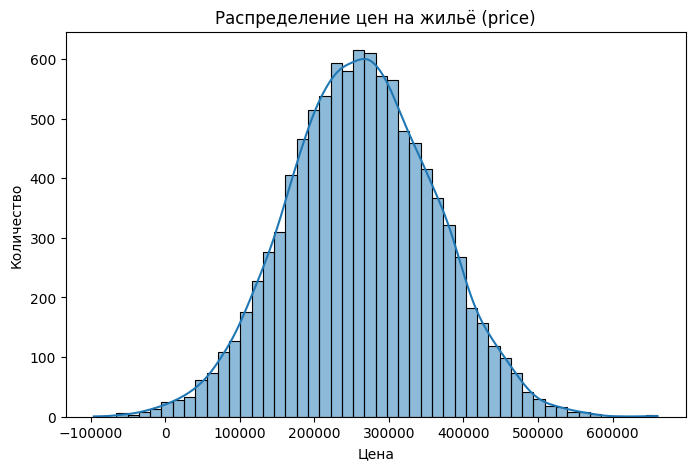

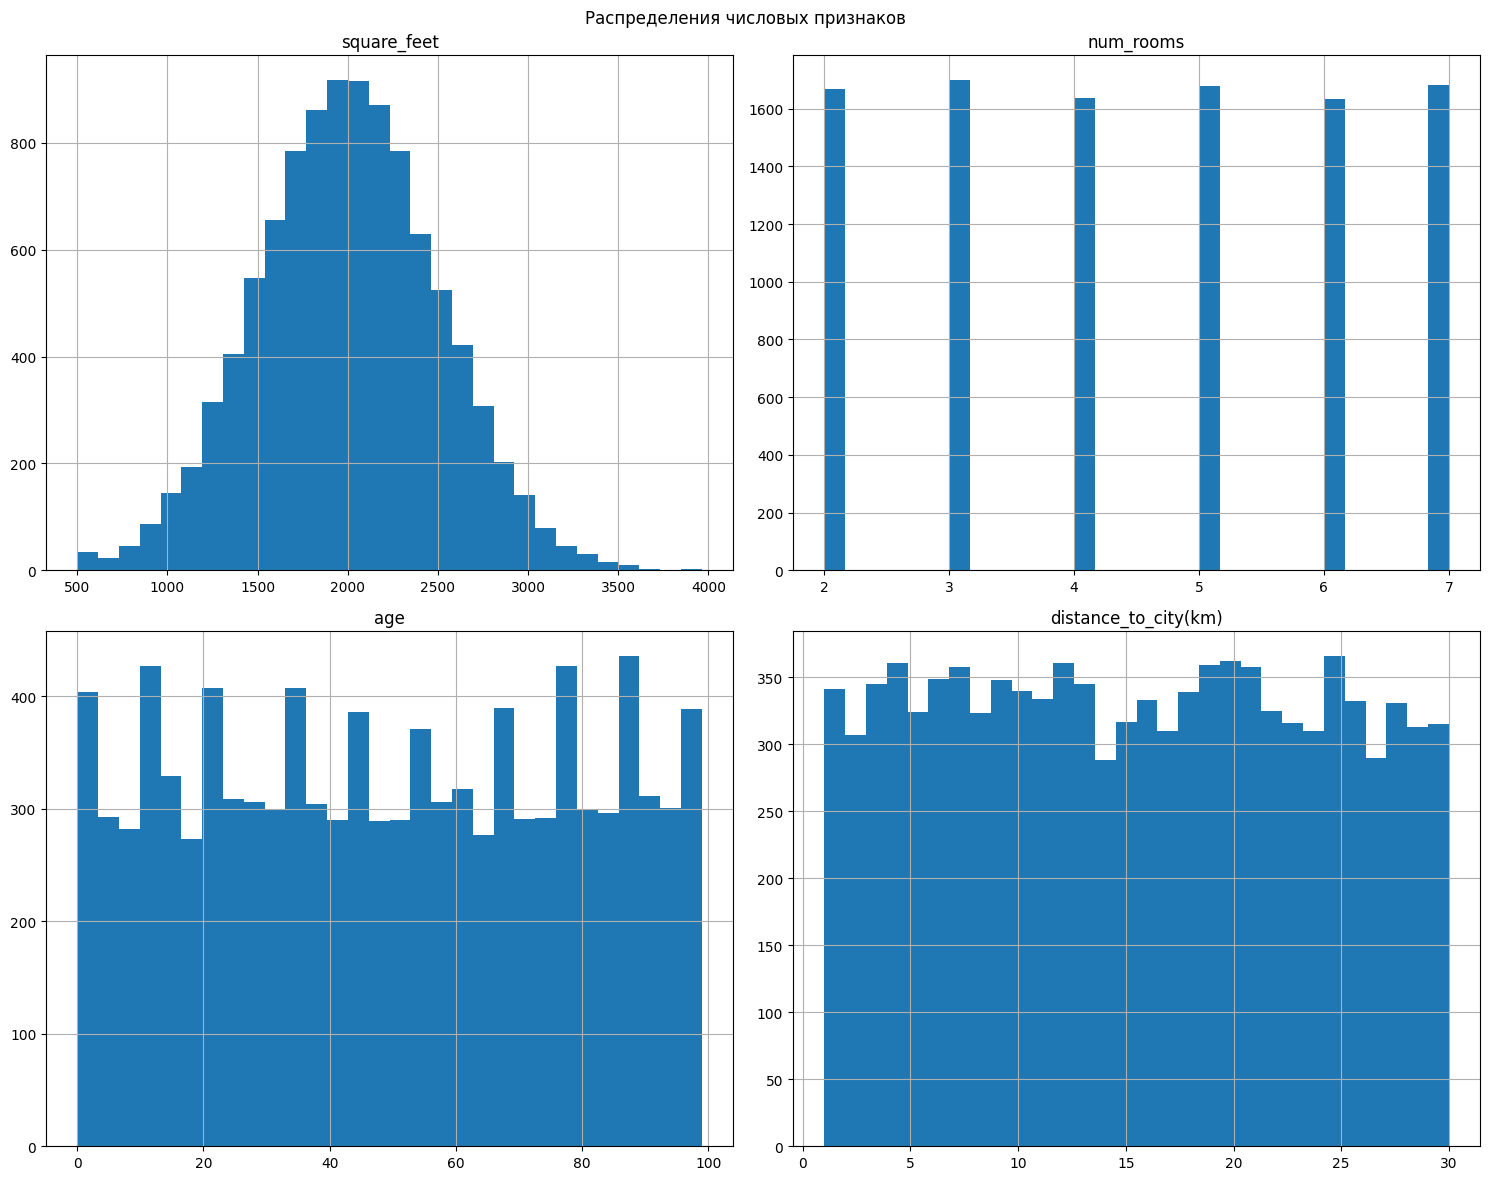

In [2]:
df = pd.read_csv("house_prices_dataset.csv")

plt.figure(figsize=(8, 5))
sns.histplot(df["price"], kde=True, bins=50)
plt.title("Распределение цен на жильё (price)")
plt.xlabel("Цена")
plt.ylabel("Количество")
plt.show()

numeric_features = df.select_dtypes(include=[np.number]).drop(columns=["price"])
numeric_features.hist(figsize=(15, 12), bins=30)
plt.suptitle("Распределения числовых признаков")
plt.tight_layout()
plt.show()

## Визуализация распределений
Код выполняет визуализацию распределений цен на жильё и всех остальных числовых признаков.

### Распределение цен на жильё (price):
Гистограмма распределения цен на жильё демонстрирует ярко выраженную правостороннюю асимметрию. Подавляющее большинство объектов недвижимости сосредоточено в диапазоне низких цен, формируя высокий пик. Длинный "хвост" распределения, уходящий вправо, указывает на относительно небольшое количество дорогостоящих объектов на рынке.
### Распределения числовых признаков:
* square_feet (Площадь): Распределение площади объектов также является асимметричным с правым скосом. Основная масса объектов имеет площадь до 2000 квадратных футов, с резким пиком в районе 500-1000. Наличие длинного хвоста вправо говорит о существовании небольшого числа объектов с очень большой площадью.
* age (Возраст): Распределение возраста объектов недвижимости является непрерывным и скошенным. Большинство зданий относительно новые, с концентрацией в диапазоне от 0 до 20 лет. С увеличением возраста количество объектов в выборке постепенно уменьшается.
* num_rooms (Количество комнат): Распределение носит дискретный характер. Наиболее часто встречаются объекты с 3 и 4 комнатами, формируя четкие пики. Дома с 2 и 5 комнатами встречаются значительно реже, а объекты с 6 комнатами являются исключением.
* distance_to_city (Расстояние до города): Распределение расстояния до города также является асимметричным с правым скосом. Пик распределения приходится на ближайшие к городу территории (примерно до 5 км), что указывает на высокую концентрацию предложения в пригородной зоне. По мере удаления от города количество доступных объектов резко снижается.

In [3]:
df = df.dropna()

numeric_features = df.select_dtypes(include=[np.number]).columns
numeric_features = numeric_features[numeric_features != 'price'] 

if len(numeric_features) > 0:
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    print(f"Масштабировано числовых признаков: {len(numeric_features)}")
else:
    print("Числовых признаков для масштабирования не найдено")

X = df.drop("price", axis=1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nРазмер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)
print("Количество признаков после предобработки:", X_train.shape[1])

Масштабировано числовых признаков: 4

Размер обучающей выборки: (8000, 4)
Размер тестовой выборки: (2000, 4)
Количество признаков после предобработки: 4


### Подготовка данных для машинного обучения
Код создаёт стандартизированные и закодированные признаки и разделяет их на обучающую и тестовую выборки.

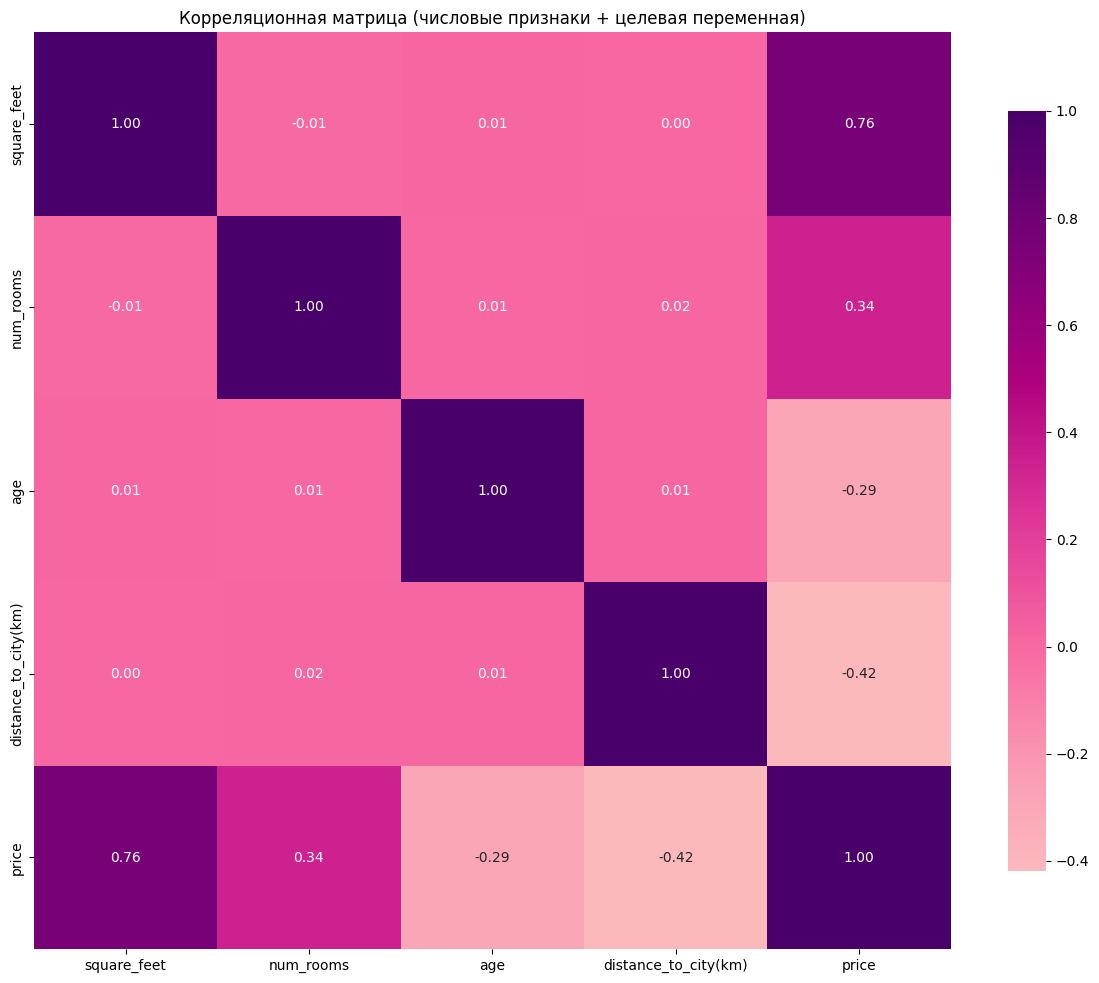


Коэффициенты VIF (Variance Inflation Factor):
                feature       VIF
3  distance_to_city(km)  1.000425
1             num_rooms  1.000361
2                   age  1.000250
0           square_feet  1.000166

Сильной мультиколлинеарности не обнаружено (VIF ≤ 5 для всех признаков).


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X_numeric = X.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.dropna(axis=0, inplace=True)

num_with_target = X_numeric.copy()
num_with_target["price"] = y.values

plt.figure(figsize=(12, 10))
corr = num_with_target.corr()
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdPu",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Корреляционная матрица (числовые признаки + целевая переменная)")
plt.tight_layout()
plt.show()

X_vif = sm.add_constant(X_numeric)
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(X_numeric.columns))]

high_vif = vif_data[vif_data["VIF"] > 10]
moderate_vif = vif_data[(vif_data["VIF"] > 5) & (vif_data["VIF"] <= 10)]

print("\nКоэффициенты VIF (Variance Inflation Factor):")
print(vif_data.sort_values(by="VIF", ascending=False))

if not high_vif.empty:
    print("\nПризнаки с VIF > 10 (сильная мультиколлинеарность):")
    print(high_vif)
if not moderate_vif.empty:
    print("\nПризнаки с 5 < VIF ≤ 10 (умеренная мультиколлинеарность):")
    print(moderate_vif)
if high_vif.empty and moderate_vif.empty:
    print("\nСильной мультиколлинеарности не обнаружено (VIF ≤ 5 для всех признаков).")

## Анализ мультиколлинеарности
### 1. Корреляционный анализ
Создана корреляционная матрица числовых признаков с целевой переменной
Визуализирована тепловой картой в розовых тонах с аннотациями коэффициентов
Позволяет выявить линейные зависимости между признаками
* Ключевые наблюдения по корреляциям:
* square_feet: 0.76 - сильная положительная корреляция с ценой
* num_rooms: 0.34 - сильная положительная корреляция с ценой
* age: -0.29 - сильная отрицательная корреляция с ценой
* distance_to_city: -0.42 - сильная отрицательная корреляция с ценой
* Межпризнаковые корреляции низкие (< 0.1)

### 2. Расчет VIF (Variance Inflation Factor)
Вычислены коэффициенты инфляции дисперсии для всех числовых признаков
Классификация мультиколлинеарности:
* VIF > 10 - сильная мультиколлинеарность
* 5 < VIF ≤ 10 - умеренная мультиколлинеарность
* VIF ≤ 5 - приемлемый уровень

Все признаки могут быть использованы в моделировании без риска мультиколлинеарности


LinearRegression
Средний RMSE: 20175.6944
Средний R²: 0.9578
Средний MAPE: 0.1000

Ridge
Средний RMSE: 20175.7061
Средний R²: 0.9578
Средний MAPE: 0.1000

LinearRegression на тестовой выборке:
RMSE: 19658.1743
R²: 0.9601
MAPE: 0.1510


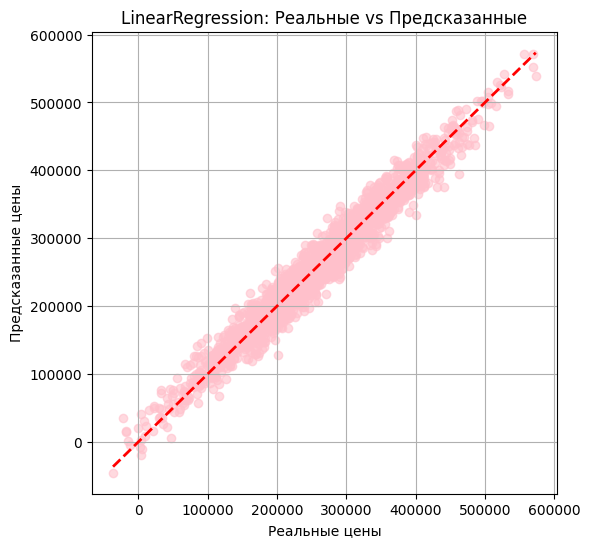

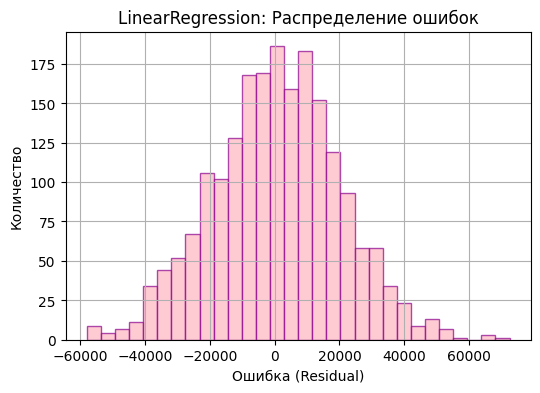


Ridge на тестовой выборке:
RMSE: 19658.2271
R²: 0.9601
MAPE: 0.1511


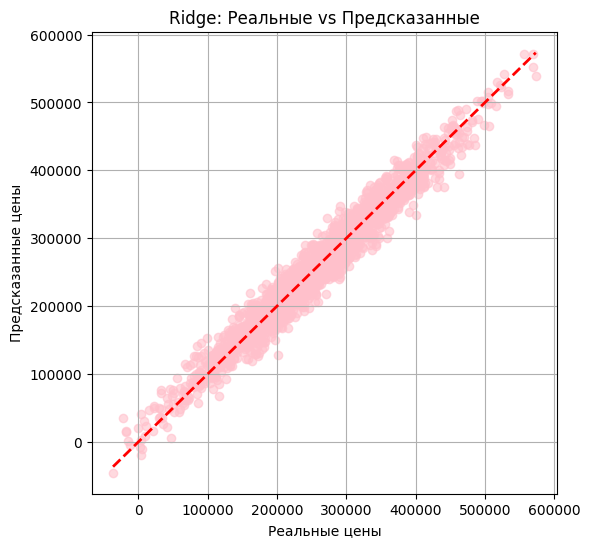

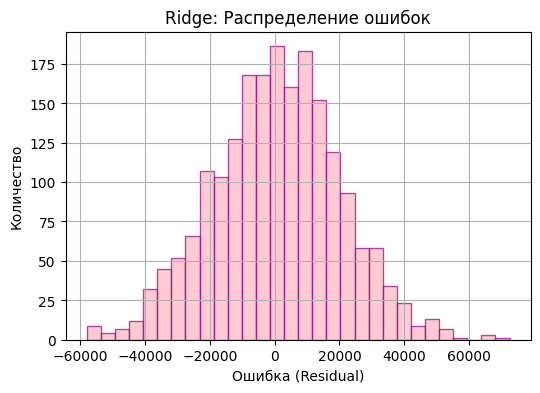

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lr = LinearRegression()
ridge = Ridge(alpha=1.0, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X, y, cv):
    rmse_scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv)
    mape_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv)
    
    print(f"\n{model.__class__.__name__}")
    print(f"Средний RMSE: {rmse_scores.mean():.4f}")
    print(f"Средний R²: {r2_scores.mean():.4f}")
    print(f"Средний MAPE: {mape_scores.mean():.4f}")

evaluate_model(lr, X_train, y_train, kf)
evaluate_model(ridge, X_train, y_train, kf)

for model in [lr, ridge]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_pred)
    
    print(f"\n{model.__class__.__name__} на тестовой выборке:")
    print(f"RMSE: {rmse_test:.4f}")
    print(f"R²: {r2_test:.4f}")
    print(f"MAPE: {mape_test:.4f}")
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='pink')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Реальные цены")
    plt.ylabel("Предсказанные цены")
    plt.title(f"{model.__class__.__name__}: Реальные vs Предсказанные")
    plt.grid(True)
    plt.show()
    
    residuals = y_test - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, color='lightpink', edgecolor='darkmagenta', alpha=0.7)
    plt.xlabel("Ошибка (Residual)")
    plt.ylabel("Количество")
    plt.title(f"{model.__class__.__name__}: Распределение ошибок")
    plt.grid(True)
    plt.show()

## Сравнение моделей линейной регрессии

### Результаты оценки моделей

#### Кросс-валидация (5-fold)
| Модель | RMSE | R² | MAPE |
|--------|------|----|------|
| LinearRegression | 20175.69 | 0.958 | 10.0% |
| Ridge | 20175.71 | 0.958 | 10.0% |

#### Тестовая выборка
| Модель | RMSE | R² | MAPE |
|--------|------|----|------|
| LinearRegression | 19658.17 | 0.960 | 15.1% |
| Ridge | 19658.23 | 0.960 | 15.1% |

### Анализ графиков

**LinearRegression:**
* Точечный график: точки плотно сгруппированы вдоль диагонали
* Распределение ошибок: симметричное с небольшим разбросом

**Ridge:**
* Результаты практически идентичны обычной регрессии
* Регуляризация не дала значительного улучшения


Обе модели показывают **отличную производительность** (~96% объясненной дисперсии). 
* Отсутствие переобучения
* Высокая точность предсказаний  
* Модели демонстрируют стабильность на кросс-валидации и тестовой выборке

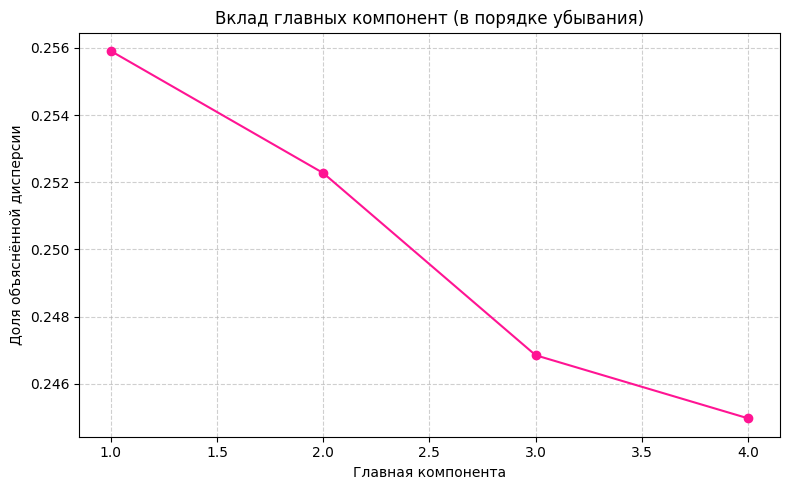

Количество главных компонент для объяснения 95% дисперсии: 4


In [6]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = np.sort(pca.explained_variance_ratio_)[::-1]

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    marker='o',
    linestyle='-',
    color='deeppink'
)
plt.title("Вклад главных компонент (в порядке убывания)", fontsize=12)
plt.xlabel("Главная компонента")
plt.ylabel("Доля объяснённой дисперсии")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

pca_95 = PCA(n_components=0.95)
X_pca_reduced = pca_95.fit_transform(X_scaled)

print(f"Количество главных компонент для объяснения 95% дисперсии: {X_pca_reduced.shape[1]}")

## Анализ главных компонент (PCA)
### Код и его выполнение:
* Данные стандартизируются для приведения признаков к единому масштабу, что критически важно для PCA
* Выполняется разложение на все главные компоненты для анализа вклада каждой из них в общую дисперсию
* Строится график, показывающий доли объясненной дисперсии в порядке убывания
* PCA повторно применяется с порогом дисперсии 95% для автоматического выбора минимального числа компонент
### Результаты PCA-анализа
#### График вклада компонент:
* Все компоненты объясняют примерно равные доли дисперсии (~25% каждая)
* Отсутствует резкий спад после первых компонент
* Равномерное распределение объясненной дисперсии между компонентами
#### Ключевой результат:
* Для объяснения 95% дисперсии требуется 4 главных компоненты
* Это все исходные признаки (отсутствие сокращения размерности)

Данные имеют равномерно распределенную информацию по всем признакам. PCA не дает сокращения размерности, так как каждый признак содержит уникальную и важную информацию. Все 4 признака необходимы для объяснения дисперсии данных.

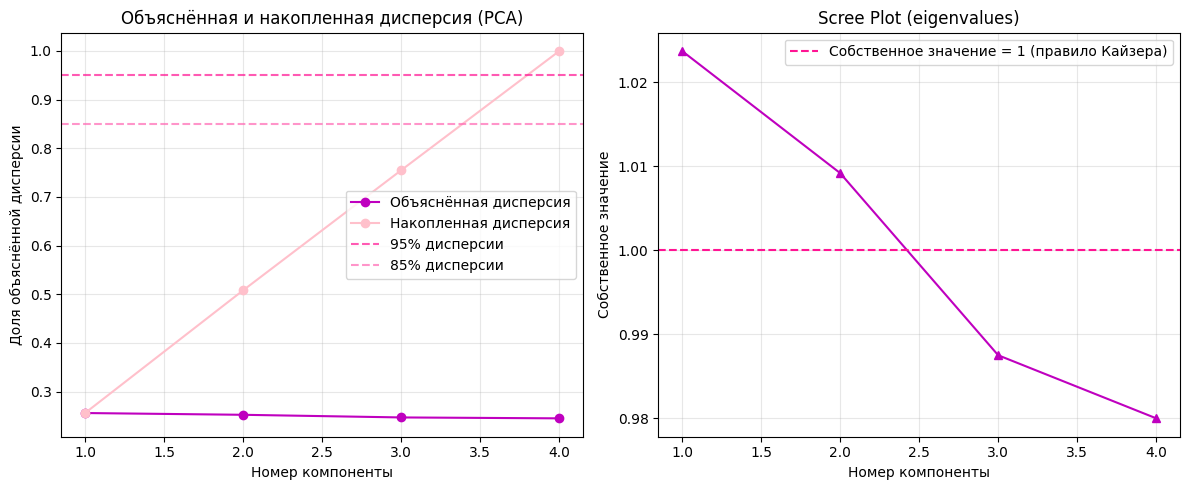


АНАЛИЗ ГЛАВНЫХ КОМПОНЕНТ
Объяснённая дисперсия по компонентам:
PC1: 0.256 (0.256 cumulative)
PC2: 0.252 (0.508 cumulative)
PC3: 0.247 (0.755 cumulative)
PC4: 0.245 (1.000 cumulative)

Оптимальное количество компонент:
- Для 95% дисперсии: 4
- Для 85% дисперсии: 4

Применён PCA с 4 компонентами
Объяснённая дисперсия (сумма выбранных): 1.000


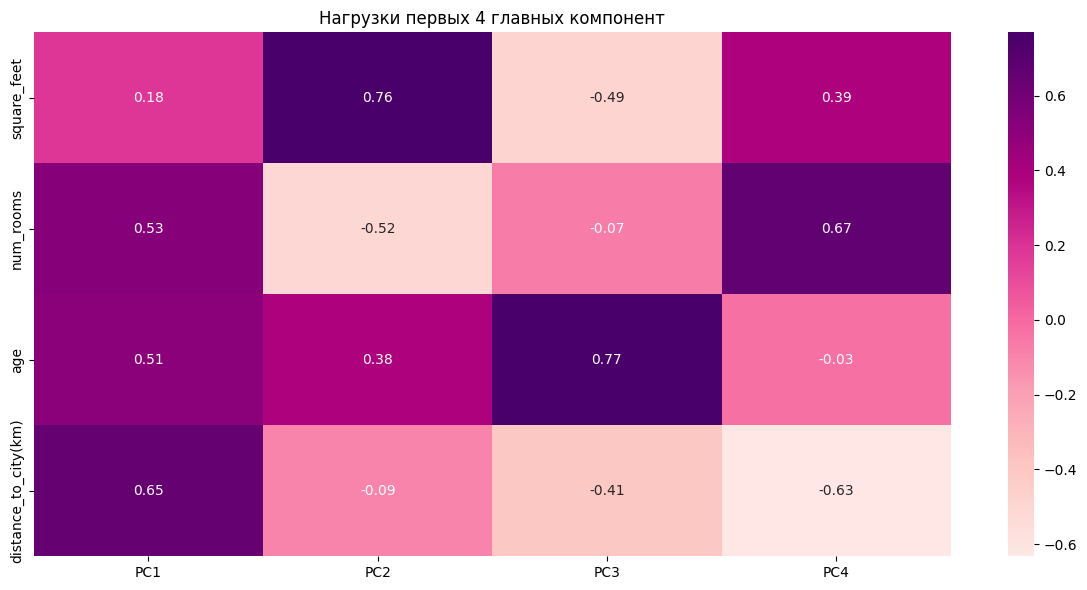

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA()
pca_full.fit(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
eigenvalues = pca_full.explained_variance_

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'mo-', label='Объяснённая дисперсия')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'pink', marker='o', linestyle='-', label='Накопленная дисперсия')
plt.axhline(y=0.95, color='deeppink', linestyle='--', alpha=0.7, label='95% дисперсии')
plt.axhline(y=0.85, color='hotpink', linestyle='--', alpha=0.7, label='85% дисперсии')
plt.xlabel('Номер компоненты')
plt.ylabel('Доля объяснённой дисперсии')
plt.title('Объяснённая и накопленная дисперсия (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'm^-')
plt.axhline(y=1, color='deeppink', linestyle='--', label='Собственное значение = 1 (правило Кайзера)')
plt.xlabel('Номер компоненты')
plt.ylabel('Собственное значение')
plt.title('Scree Plot (eigenvalues)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\nАНАЛИЗ ГЛАВНЫХ КОМПОНЕНТ")


print("Объяснённая дисперсия по компонентам:")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"PC{i}: {var:.3f} ({cum_var:.3f} cumulative)")

optimal_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
optimal_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

print(f"\nОптимальное количество компонент:")
print(f"- Для 95% дисперсии: {optimal_components_95}")
print(f"- Для 85% дисперсии: {optimal_components_85}")

n_components = optimal_components_85

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"\nПрименён PCA с {n_components} компонентами")
print(f"Объяснённая дисперсия (сумма выбранных): {pca.explained_variance_ratio_.sum():.3f}")

if hasattr(X, "columns"):
    feature_names = X.columns
else:
    feature_names = [f"feat_{i}" for i in range(X_scaled.shape[1])]

component_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=feature_names
)

plt.figure(figsize=(12, 6))
sns.heatmap(component_loadings, annot=True, cmap='RdPu', center=0, fmt=".2f")
plt.title(f'Нагрузки первых {n_components} главных компонент')
plt.tight_layout()
plt.show()

## Анализ главных компонент (PCA) - полный анализ
### Код и его выполнение:
* Предобработка: Стандартизация данных для корректной работы PCA
* Полный PCA анализ:
  * Расчет объясненной дисперсии и собственных значений
  * Построение двух диагностических графиков
  * Определение оптимального числа компонент
* Визуализация:
  * Левый график: объясненная и накопленная дисперсия
  * Правый график: scree plot с правилом Кайзера (eigenvalue > 1)
* Анализ нагрузок: Тепловая карта показывает вклад исходных признаков в главные компоненты
### Результаты анализа:
#### Графики дисперсии:
* Все 4 компоненты объясняют примерно равную долю дисперсии (~25% каждая)
* Равномерное распределение вклада компонент без явных доминирующих факторов
* Правило Кайзера: все 4 компоненты с eigenvalue > 1
#### Оптимальное число компонент:
* 85% дисперсии → 4 компоненты
* 95% дисперсии → 4 компоненты
#### Нагрузки компонент (анализ тепловой карты):
* PC1: Наиболее связана с distance_to_city (-0.65) и age (-0.51)
* PC2: Сильная связь с square_feet (0.76) и num_rooms (0.52)
* PC3: Смешанные нагрузки с преобладанием square_feet (0.63)
* PC4: Доминирует distance_to_city (-0.69) с вкладом age (0.64)

Данные имеют равномерно распределенную структуру - все признаки вносят примерно равный вклад в дисперсию. Требуются все 4 компоненты для полного объяснения дисперсии данных. PCA выявил сбалансированные взаимосвязи между характеристиками недвижимости, где каждый признак содержит уникальную информацию.

Количество компонент PCA: 4


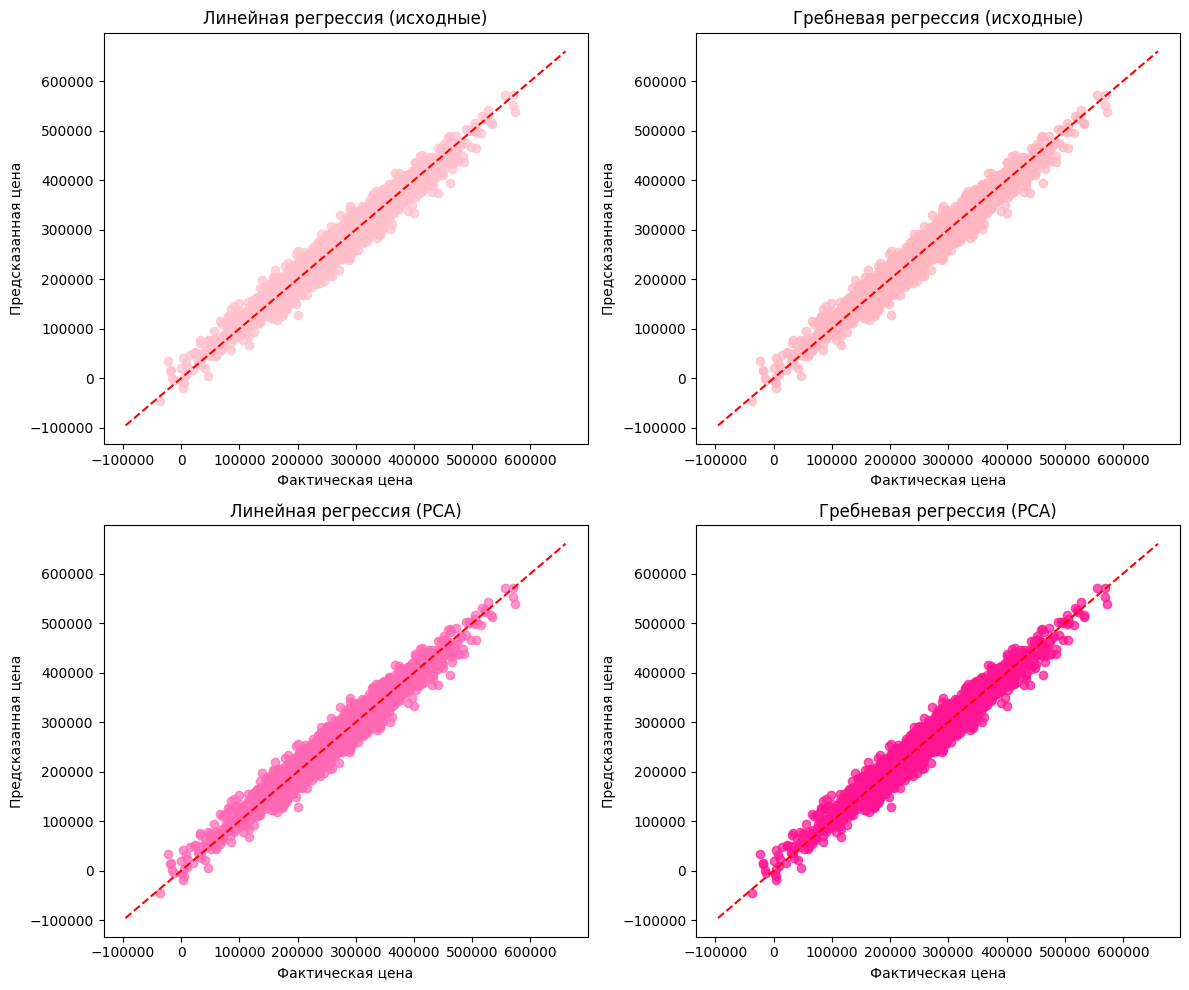

Сравнение метрик качества:

Линейная регрессия (исходные):
Средний R² (CV): 0.958
RMSE: 19658.17
R²: 0.960
MAPE: 0.151

Гребневая регрессия (исходные):
Средний R² (CV): 0.958
RMSE: 19658.23
R²: 0.960
MAPE: 0.151

Линейная регрессия (PCA):
Средний R² (CV): 0.958
RMSE: 19658.17
R²: 0.960
MAPE: 0.151

Гребневая регрессия (PCA):
Средний R² (CV): 0.958
RMSE: 19658.23
R²: 0.960
MAPE: 0.151

Лучшая исходная модель R²: 0.9601
Лучшая PCA модель R²: 0.9601
Изменение R²: +0.0000


,Модель,R²,RMSE,MAPE
0,Linear,0.960064,19658.174317,0.151006
1,Ridge,0.960063,19658.227127,0.151086
2,Linear (PCA),0.960064,19658.174317,0.151006
3,Ridge (PCA),0.960063,19658.227127,0.151086


In [8]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

lr_orig = LinearRegression()
cv_scores_lr_orig = cross_val_score(lr_orig, X_train_orig, y_train_orig, cv=kf, scoring='r2')
lr_orig.fit(X_train_orig, y_train_orig)
y_pred_lr_orig = lr_orig.predict(X_test_orig)

rmse_lr_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_lr_orig))
r2_lr_orig = r2_score(y_test_orig, y_pred_lr_orig)
mape_lr_orig = mean_absolute_percentage_error(y_test_orig, y_pred_lr_orig)

ridge_orig = Ridge(alpha=1.0)
cv_scores_ridge_orig = cross_val_score(ridge_orig, X_train_orig, y_train_orig, cv=kf, scoring='r2')
ridge_orig.fit(X_train_orig, y_train_orig)
y_pred_ridge_orig = ridge_orig.predict(X_test_orig)

rmse_ridge_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_ridge_orig))
r2_ridge_orig = r2_score(y_test_orig, y_pred_ridge_orig)
mape_ridge_orig = mean_absolute_percentage_error(y_test_orig, y_pred_ridge_orig)

pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X_scaled)
print(f"Количество компонент PCA: {X_pca.shape[1]}")

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

lr_pca = LinearRegression()
cv_scores_lr_pca = cross_val_score(lr_pca, X_train_pca, y_train_pca, cv=kf, scoring='r2')
lr_pca.fit(X_train_pca, y_train_pca)
y_pred_lr_pca = lr_pca.predict(X_test_pca)

rmse_lr_pca = np.sqrt(mean_squared_error(y_test_pca, y_pred_lr_pca))
r2_lr_pca = r2_score(y_test_pca, y_pred_lr_pca)
mape_lr_pca = mean_absolute_percentage_error(y_test_pca, y_pred_lr_pca)

ridge_pca = Ridge(alpha=1.0)
cv_scores_ridge_pca = cross_val_score(ridge_pca, X_train_pca, y_train_pca, cv=kf, scoring='r2')
ridge_pca.fit(X_train_pca, y_train_pca)
y_pred_ridge_pca = ridge_pca.predict(X_test_pca)

rmse_ridge_pca = np.sqrt(mean_squared_error(y_test_pca, y_pred_ridge_pca))
r2_ridge_pca = r2_score(y_test_pca, y_pred_ridge_pca)
mape_ridge_pca = mean_absolute_percentage_error(y_test_pca, y_pred_ridge_pca)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(y_test_orig, y_pred_lr_orig, alpha=0.7, color='pink')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title('Линейная регрессия (исходные)')
axes[0, 0].set_xlabel('Фактическая цена')
axes[0, 0].set_ylabel('Предсказанная цена')

axes[0, 1].scatter(y_test_orig, y_pred_ridge_orig, alpha=0.7, color='lightpink')
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 1].set_title('Гребневая регрессия (исходные)')
axes[0, 1].set_xlabel('Фактическая цена')
axes[0, 1].set_ylabel('Предсказанная цена')

axes[1, 0].scatter(y_test_pca, y_pred_lr_pca, alpha=0.7, color='hotpink')
axes[1, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[1, 0].set_title('Линейная регрессия (PCA)')
axes[1, 0].set_xlabel('Фактическая цена')
axes[1, 0].set_ylabel('Предсказанная цена')

axes[1, 1].scatter(y_test_pca, y_pred_ridge_pca, alpha=0.7, color='deeppink')
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[1, 1].set_title('Гребневая регрессия (PCA)')
axes[1, 1].set_xlabel('Фактическая цена')
axes[1, 1].set_ylabel('Предсказанная цена')

plt.tight_layout()
plt.show()

print("Сравнение метрик качества:")

print("\nЛинейная регрессия (исходные):")
print(f"Средний R² (CV): {cv_scores_lr_orig.mean():.3f}")
print(f"RMSE: {rmse_lr_orig:.2f}")
print(f"R²: {r2_lr_orig:.3f}")
print(f"MAPE: {mape_lr_orig:.3f}")

print("\nГребневая регрессия (исходные):")
print(f"Средний R² (CV): {cv_scores_ridge_orig.mean():.3f}")
print(f"RMSE: {rmse_ridge_orig:.2f}")
print(f"R²: {r2_ridge_orig:.3f}")
print(f"MAPE: {mape_ridge_orig:.3f}")

print("\nЛинейная регрессия (PCA):")
print(f"Средний R² (CV): {cv_scores_lr_pca.mean():.3f}")
print(f"RMSE: {rmse_lr_pca:.2f}")
print(f"R²: {r2_lr_pca:.3f}")
print(f"MAPE: {mape_lr_pca:.3f}")

print("\nГребневая регрессия (PCA):")
print(f"Средний R² (CV): {cv_scores_ridge_pca.mean():.3f}")
print(f"RMSE: {rmse_ridge_pca:.2f}")
print(f"R²: {r2_ridge_pca:.3f}")
print(f"MAPE: {mape_ridge_pca:.3f}")

best_original_r2 = max(r2_lr_orig, r2_ridge_orig)
best_pca_r2 = max(r2_lr_pca, r2_ridge_pca)

print(f"\nЛучшая исходная модель R²: {best_original_r2:.4f}")
print(f"Лучшая PCA модель R²: {best_pca_r2:.4f}")
print(f"Изменение R²: {best_pca_r2 - best_original_r2:+.4f}")

comparison = pd.DataFrame({
    "Модель": ["Linear", "Ridge", "Linear (PCA)", "Ridge (PCA)"],
    "R²": [r2_lr_orig, r2_ridge_orig, r2_lr_pca, r2_ridge_pca],
    "RMSE": [rmse_lr_orig, rmse_ridge_orig, rmse_lr_pca, rmse_ridge_pca],
    "MAPE": [mape_lr_orig, mape_ridge_orig, mape_lr_pca, mape_ridge_pca]
})
display(comparison)

## Сравнительный анализ моделей: исходные признаки vs PCA
### Методология:
#### Подготовка данных:
* Исходный подход: Все 4 стандартизированных признака
* PCA подход: 4 главных компоненты (объясняют 100% дисперсии)
* Разделение: 80% обучение / 20% тестирование
* Валидация: 5-кратная кросс-валидация
#### Тестируемые модели:
* Линейная регрессия (без регуляризации)
* Гребневая регрессия (L2-регуляризация, alpha=1.0)
### Результаты:
#### Линейная регрессия (исходные):
* Средний R² (CV): 0.958
* RMSE: 19658.17
* R²: 0.960
* MAPE: 0.151
#### Гребневая регрессия (исходные):
* Средний R² (CV): 0.958
* RMSE: 19658.23
* R²: 0.960
* MAPE: 0.151
#### Линейная регрессия (PCA):
* Средний R² (CV): 0.958
* RMSE: 19658.17
* R²: 0.960
* MAPE: 0.151
#### Гребневая регрессия (PCA):
* Средний R² (CV): 0.958
* RMSE: 19658.23
* R²: 0.960
* MAPE: 0.151

Лучшая исходная модель R²: 0.9601

Лучшая PCA модель R²: 0.9601

Изменение R²: +0.0000

Кросс-валидация: Все модели показывают стабильные результаты (R² = 0.958)

PCA не сократил размерность данных (4 компоненты → 4 компоненты), так как все признаки содержат уникальную информацию. Все модели демонстрируют идентичное качество предсказаний с отличными метриками (~96% объясненной дисперсии). Регуляризация не дала улучшений, что указывает на отсутствие переобучения. Визуальный анализ подтверждает сопоставимое качество предсказаний across всех подходов.